weight: [[ 4.9699454  1.1948917 -3.3782742  5.630791 ]]
tensor([ 5.0000,  1.2000, -3.4000,  5.6000])


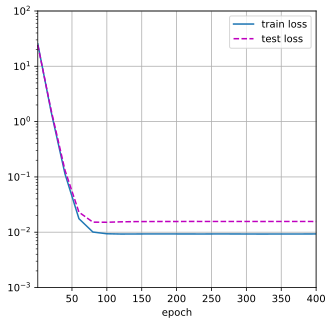

In [73]:
import torch
import math
from ch3 import *

n_feature = 20
n_train = 100
n_validate = 100

feature = torch.randn([n_train + n_validate, n_feature])
feature = torch.pow(feature, torch.arange(n_feature)) / torch.tensor([math.factorial(n) for n in range(n_feature)])

true_w = torch.tensor([5, 1.2, -3.4, 5.6], dtype=torch.float)
label = torch.matmul(feature[:, 0:4], true_w) + torch.normal(0, 0.1, size=[n_train + n_validate])

def evaluate_accuracy(net, data_iter, loss):
    if isinstance(net, torch.nn.Module):
        net.eval() 
    metric = Accumulator(2) 
    with torch.no_grad():
        for X, y in data_iter:
            y_hat = net(X)
            y = y.reshape(y_hat.shape)
            l = loss(y_hat, y)
            metric.add(l.item() * y.numel(), y.numel())
    return metric[0] / metric[1]

def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    if isinstance(net, nn.Module):
        net.train()
    metric = Accumulator(2)
    for X, y in train_iter:
        y_hat = net(X)
        y = y.reshape(y_hat.shape)
        l = loss(y_hat, y)
        l.backward()
        updater.step()
        updater.zero_grad()
        metric.add(l.item() * y.numel(), y.numel())
    return metric[0] / metric[1]

def train(features, labels, n_train, num_epochs):  #@save
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[1e-3, 1e2], yscale='log',
                        legend=['train loss', 'test loss'], nrows=1, ncols=1)

    train_features = features[:n_train]
    train_labels = labels[:n_train]
    test_features = features[n_train:]
    test_labels = labels[n_train:]

    net = nn.Sequential(nn.Linear(train_features.shape[-1], 1, bias=False))
    loss = nn.MSELoss()
    updater = torch.optim.SGD(net.parameters(), lr=0.01)

    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels),batch_size)
    test_iter = d2l.load_array((test_features, test_labels),batch_size, is_train=False)

    for epoch in range(num_epochs):
        loss_train  = train_epoch_ch3(net, train_iter, loss, updater)
        loss_test = evaluate_accuracy(net, test_iter, loss)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (loss_train, loss_test))
    print('weight:', net[0].weight.data.numpy())

train(feature[:, 0:4], label, n_train, 400)
print(true_w)

weight: [[ 4.975055    1.304701   -3.3752635   5.102871   -0.06567819  1.3221266
   0.3133003   0.2222411  -0.09624584  0.06368671  0.1449356   0.20325746
   0.17580517  0.19126675  0.08495517 -0.19870357  0.1816799   0.16141146
   0.05874956  0.17994818]]


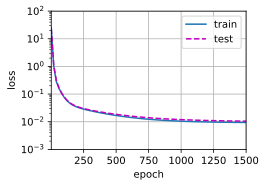

In [72]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
   torch.float32) for x in [true_w, features, poly_features, labels]]
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], 400)

In [66]:
feature[0:2, :]

tensor([[ 1.0000e+00, -3.0409e-01,  1.5248e-01,  1.4794e-01,  1.2408e-09,
          1.2043e-03,  3.4481e-04,  2.2234e-03,  6.2498e-05, -1.0317e-09,
          1.3062e-10,  7.8187e-11,  4.0533e-16, -7.2360e-13,  1.0926e-25,
          3.3052e-12,  8.8127e-10,  5.0652e-20,  2.0509e-19, -7.2290e-29],
        [ 1.0000e+00, -1.8635e+00,  3.8604e-01, -2.4203e-02,  3.5352e-03,
          1.2036e-02,  5.3284e-03, -1.8979e-07,  6.0250e-11,  2.9997e-02,
          7.9312e-08,  4.2269e-12,  5.8534e-08, -1.1187e-08,  2.7114e-13,
         -7.5026e-15,  3.6715e-15,  4.7268e-16,  1.6838e-12,  2.8861e-21]])